# A1: Predicting Air Quality with Sine Functions

*type your name here*

Instructions:  Run all of the code given here to make sure it runs with no errors.  Then develop the code requested at the bottom of this notebook and type your discussion of the results.

Delete this markdown cell.

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas

# Sine Transform

As we have seen in our recent lecture notes, the air quality data shows variations in CO with time of day.  We have used linear models and simple nonlinear models based on polynomial transformations of the input variable, the hour of the day.

In this assignment, you will explore transformations of the input variable using a sine function.  You will use the sine function

$$ y(x) = \sin(shift + scale\cdot x) \; W$$

where the values of $shift$ and $scale$ control the translation and frequency of the sine function.  Notice that if $x$ is $N\times 1$, a matrix containing $N$ samples each with 1 component, or dimension, and $shift$ and $scale$ are both $1\times S$, matrices containing 1 row and shifts and scales for $S$ different sine functions, then $y(x)$ will be $N\times S$.

For example, if $x \in (0, 23)$ representing the hour of the day, several sine functions for different values of $shift$ and $scale$ are shown below.  

With `shifts` and `scales` being equal length lists or vectors, we can transform samples in `X` having one column into multiple columns that are different sine functions applied to each sample.

In [44]:
def sine_transform(X, shifts, scales):
    return np.sin(shifts + scales * X)

In [47]:
# Here we are specifying four different sine functions.
shifts = [0, 5, 2, -3]
scales = [0, 0.2, 1, 2]

# Apply each sine function to the 100 samples in X.
Xs = np.linspace(0, 24, 100).reshape(-1, 1)
X_sines = sine_transform(Xs, shifts, scales)
X_sines.shape

(100, 4)

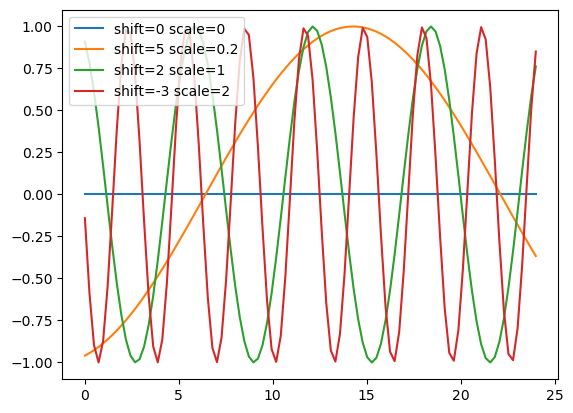

In [6]:
for i in range(X_sines.shape[1]):  # number of columns
    plt.plot(Xs, X_sines[:, i], label=f'shift={shifts[i]} scale={scales[i]}')
plt.legend();

# Nonlinear model based on sine transform and our previous linear modeld.

In [7]:
def sine_model(X_sines, W):
    y = W[0] + X_sines @ W[1:]
    return y                   

In [8]:
shifts = [0, 2, -3]
scales = [0.2, 1, 2]
W = np.ones((len(shifts) + 1, 1))

Xs = np.linspace(0, 24, 10).reshape(-1, 1)
X_sines = sine_transform(Xs, shifts, scales)
print(X_sines.shape, W.shape)
sine_model(X_sines, W)

(10, 3) (4, 1)


array([[ 1.76817742],
       [ 1.23253752],
       [ 3.72559988],
       [ 1.87571953],
       [ 1.45243426],
       [ 0.8286791 ],
       [-0.47299527],
       [ 1.63432375],
       [ 0.04603696],
       [ 1.61729737]])

# Finding best sine function shifts and scales and best weights W

To find the best parameters for our sine model, we must define the RMSE and gradient functions.

In [9]:
def rmse(model, X_sines, T, W):
    Y = model(X_sines, W)
    return np.sqrt(np.mean((T - Y)**2))

In [14]:
# Gradient of Y with respect to W
def dYdW(X_sines, T, W):
    return np.insert(X_sines, 0, 1, 1)   # WHAT IS GOING ON HERE???

#Gradient of E with respect to Y
def dEdY(X_sines, T, W):
    Y = sine_model(X_sines, W)
    return -2 * (T - Y)
    
# Gradient of E with respect to W.
def dEdW(X_sines, T, W):
    n_samples = X_sines.shape[0]
    result = dYdW(X_sines, T, W).T @ dEdY(X_sines, T, W) / n_samples
    return result

Now we can test these functions.

In [15]:
Xs = np.linspace(0, 24, 10).reshape(-1, 1)
T = np.arange(10).reshape(-1, 1)

np.hstack((Xs, T))

array([[ 0.        ,  0.        ],
       [ 2.66666667,  1.        ],
       [ 5.33333333,  2.        ],
       [ 8.        ,  3.        ],
       [10.66666667,  4.        ],
       [13.33333333,  5.        ],
       [16.        ,  6.        ],
       [18.66666667,  7.        ],
       [21.33333333,  8.        ],
       [24.        ,  9.        ]])

In [16]:
shifts = [0, 2, -3]
scales = [0.2, 1, 2]
W = np.zeros((len(shifts) + 1, 1))
X_sines = sine_transform(Xs, shifts, scales)

print(rmse(sine_model, X_sines, T, W))
print(dEdY(X_sines, T, W).shape)
print(dYdW(X_sines, T, W).shape)
print(dEdW(X_sines, T, W).shape)


5.338539126015656
(10, 1)
(10, 4)
(4, 1)


Use the `adamw` optimization function to find the best weights `W`, given sine transformed inputs `X_sines`.

In [49]:
def adamw(model_f, gradient_f, rmse_f, X_sines, T, W, learning_rate, nSteps):
    
    # Commonly used parameter values
    alpha = learning_rate
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8
    W_decay_rate = 0.0   # set to zero for adam algorithm
    
    m = 0
    v = 0
    
    error_sequence = []
    W_sequence = []
    
    for step in range(nSteps):
        
        error_sequence.append(rmse_f(model_f, X_sines, T, W))
        W_sequence.append(W.flatten())
        
        grad = gradient_f(X_sines, T, W)
        
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad * grad

        mhat = m / (1 - beta1 ** (step+1))
        vhat = v / (1 - beta2 ** (step+1))
        
        W -= alpha * mhat / (np.sqrt(vhat) + epsilon) + W_decay_rate * W

    return W, error_sequence, W_sequence

Now we can use these functions to find the best values for `shifts` and `scales`.  Do so by epeatedly choosing random values of `shifts` and `scales`, using `adamw` to train a model using sine functions with these random values, calculate the RMSE of the model, and remember the values of `shifts` and `scales` that result in the lowest RMSE on the air quality data.

In [50]:
data = pandas.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',', usecols=range(15), na_values=-200)
data = data.dropna(axis=0)
hour = [int(t[:2]) for t in data['Time']]
CO = data['CO(GT)']
T = CO
T = np.array(T).reshape((-1, 1))  # make T have one column and as many rows as needed to hold the values of T
Tnames = ['CO']

X = np.array(hour).reshape((-1, 1))
Xnames = ['Hour']

Here is an example, using `shift` values randomly chosen between  $-10$ and 10 and `scale` values randomly chosen between 0 and 2.  You may change these ranges if you find different ranges work better.

Also, `n_sine_functions` is set to 3.  You may change this also to vary the number of sine functions of `X` you want to try.

You can also vary `nSteps` and `learning_rate` values used by `adamw`.

shifts = [-2.37306857 -3.17278126  1.66433366]
scales = [0.42809144 1.18156675 1.47175745]
RMSE = 1.3752105797640937


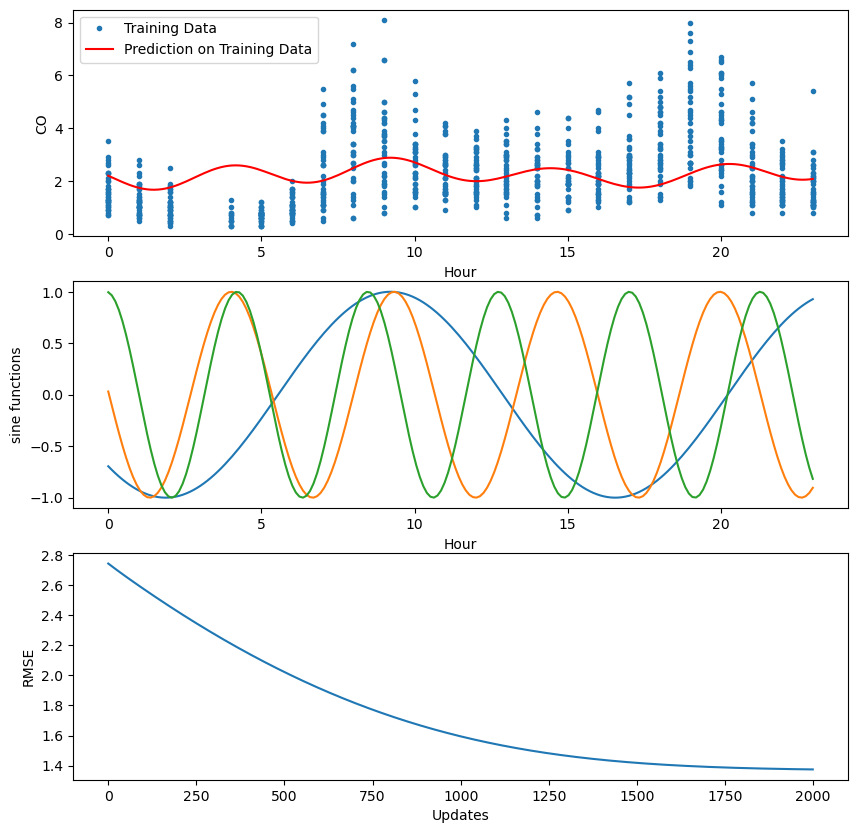

In [52]:
shift_range = (-10, 10)
scale_range = (0, 2)

n_sine_functions = 3

shifts = np.random.uniform(shift_range[0], shift_range[1], n_sine_functions)
scales = np.random.uniform(scale_range[0], scale_range[1], n_sine_functions)
W = np.zeros(1 + n_sine_functions).reshape(-1, 1)

X_sines = np.sin(shifts + scales * X)

nSteps = 2000
learning_rate = 0.002

W, error_sequence, W_sequence = adamw(sine_model, dEdW, rmse, X_sines, T, W, learning_rate, nSteps)
err = rmse(sine_model, X_sines, T, W)

print('shifts =', shifts)
print('scales =', scales)
print('RMSE =', err)

plt.figure(figsize=(10, 10))

plt.subplot(3, 1, 1)
plt.plot(X, T, '.', label='Training Data')
xs = np.linspace(0, 23, 200).reshape(-1, 1)
xs_sines = sine_transform(xs, shifts, scales)
plt.plot(xs, sine_model(xs_sines, W), 'r', label='Prediction on Training Data')
plt.xlabel(Xnames[0])
plt.ylabel(Tnames[0])
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(xs, xs_sines)
plt.xlabel(Xnames[0])
plt.ylabel('sine functions')

plt.subplot(3, 1, 3)
plt.plot(error_sequence)
plt.xlabel('Updates')
plt.ylabel('RMSE');

# Your Assignment Code Starts Here

Now here is your assignment.  Do these steps:

1. Copy and paste the above code cell below here.
1. Write a loop the repeats for some number of repetitions, such as 500, that repeats the non-plotting steps (roughly the first half of the code cell).
    1. For each repetition, calculate the RMSE.
    1. If this RMSE is lower than the current best RMSE, update the values of variables with names `best_rmse`, `best_shifts`, `best_scales` and `best_W`. Also print the repetition number, and the new values of `best_rmse`, `best_shifts`, `best_scales` and `best_W`.
    1. Append the current `best_rmse`, which may not have changed, to a list called `repetitions_error_sequence`.
1. When all repetitions have completed, execute the plotting code, copied from the previous code cell, using the values of `best_shifts`, `best_scales`, and `best_W`.

In the following markdown cell, use at least 10 sentences to describe what you see in the final plots, and also answer these questions.

1. Did you find a pretty good model of the air quality data?
2. What range of `shifts` and `scales` did you find worked best?
2. How many repetitions of random `shifts` and `scales` worked well?
3. What values of `n_sine_functions` worked well, and what values did not work well?
4. What was the hardest part of this assignment?

Here is my discussion of my results and answers to the above questions.

...

When you have finished, rename your notebook `A1solution.ipynb` and check it in in Canvas.

# Extra Credit  (leave this section heading for us to find your extra credit work)

Using a model with a single sine function applied to `X`, do the following steps.
1. Derive the gradient of the sum of squared errors with respect to the sine functions `shift` and `scale` parameters.  
1. Make the modifications needed in your code to optimize `W` (as before) and also the `shift` and `scale` parameters of a single sine function. Show the results as the three plots we have already used. The middle plot will just show one sine function with the optimized `shift` and `scale` parameters.

Earn 1 extra credit point for each of these steps.

